# In this work, only LoF mutations are used: calculate how many risk genes we can obtain with Nsample = 550

## Some ways have been used:

### Don't know any count information $=>$ use Poisson distribution

### Know counts from published data (Removed)

### Use TADA method (Removed)

### Use the trio package (Removed)

I randomly chose 1000 genes, but it's probably better if choosing top 1000 genes from TADA results.

# Simulate counts from the Poisson distribution

## Some main steps:

nGene = Number of genes ( ~ 18500 genes)

. Randomly choose risk genes with prob = 1000/nGene

. Add relative risk into mutation rates of risk genes 

. Use Poisson distribution to sample all genes with new mutation rates

. Use Poisson test to obtain p values:

    At the $i^{th}$ gene, $p_value = P(X >= x_i| lambda = 2*Nsample*mu_i)$
 
 . Count genes with pvalues < 0.05
 
 Didn't adjust for all tests, with Nsample = 550: it's difficult to obtain significant values after adjustment


# Real counts from published data

## Use the data of AUT + EPI

Take a quick look at all information

#### DISEASE	NUM_INDIV

AUT	3985

CHD	362

EPI	356

ID	192

SCZ	1024

SIB_CONTROL	2049

### wc -l AUT+EPI.LoF.mut 

  637

(3985 AUT + 356 EPI) samples have 637 LoF mutations



### We will use the Autism data from the TADA paper to have obtain some neccessary information

In [10]:
data <- read.csv("TADA/data/TADA_results.csv", header = TRUE, as.is = TRUE)
mu <- data$mut.rate
mu.frac <- c(0.074, 0.32)

Nsample_old <- 2231 ##There are 308 de novo mutations in this sample set
Nsample <- 550
Ncount_old <- sum(data$dn.LoF)
nDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )
nDenovo

mutLoF0 <- data$mut.rate*mu.frac[1] #(mu.frac[1]) # + mu.frac[2]) ##Mutation rates
nGene <- length(mutLoF0)

##Choose nRiskGene = 1000 genes, using index
indexRiskGene <- sample(1:nGene, 1000)

Ntimes <- 100 ##Do this work Ntimes
geneCountforPower2 <- NULL
geneCountforPowerList2 <- list()
geneCountList <- list()

poissonTestAll_data_allSimu <- NULL
poissonTestAll_data <- NULL

[1] 76

In [11]:
for (kk in 1:Ntimes) {

#rrList <- seq(1, 30, by = 1)
rrList <- c(1, 2, 5, 10, 20, 25, 50)
finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)
geneCountTable <- matrix(0, ncol = length(rrList), nrow = nGene)

##Add relative risks to risk genes
piRG <- 1000/nGene ##Proportion of risk genes
z <- rbinom(nGene, 1, piRG)
table(z)
for (ii in 1:length(rrList)){
  RR <- rrList[ii]

  mutLoF <- mutLoF0
  
#  mutLoF[z==1] <- mutLoF[z==1]*RR ##*rgamma(mutLoF[z==1], RR, rate = 1)
  mutLoF[1:1000] <- mutLoF[1:1000]*RR #rgamma(1000, RR, rate = 1)
  
  geneCount <- rpois(nGene, 2*mutLoF*Nsample)

    
    
  poissonTest <- ppois(geneCount - 1, lambda = 2*Nsample*mutLoF0, lower.tail = FALSE)
  
    mutLoFallDenovo <- mutLoF0[geneCount > 0]
    poissonTestAll <- ppois(sum(geneCount) - 1, sum(mutLoF0)*2*Nsample, lower.tail = FALSE)
    
    poissonTestAll_data[ii] <- poissonTestAll
    
  finalResult[, ii] <- poissonTest
  geneCountTable[, ii] <- geneCount
}

#apply(finalResult, 2, range)
t1 <- apply(finalResult, 2, function(x) length(x[x < 0.05]))
geneCountList[[kk]] <- geneCountTable

geneCountforPower2 <- rbind(geneCountforPower2, t1)
geneCountforPowerList2[[kk]] <- finalResult

    poissonTestAll_data_allSimu <- rbind(poissonTestAll_data_allSimu, poissonTestAll_data)
}


In [12]:
 ppois(sum(geneCount) - 1, sum(mutLoF0)*2*Nsample, lower.tail = FALSE)


[1] 2.952857e-36

In [13]:
allOut2 <- do.call(rbind, geneCountforPowerList2)


In [14]:
t2 <- t(apply(allOut2, 2, range)) ##Take a look at the smallest p of RR = 1
t2


8.180002e-07,1.000000e+00
4.807385e-07,1.000000e+00
2.158036e-06,1.000000e+00
2.108806e-07,1.000000e+00
6.548512e-09,1.000000e+00
1.321606e-09,1.000000e+00
1.652986e-13,1.000000e+00


In [15]:
gCountAll <- NULL
alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){
  
outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y)
    length(y[y < alphaThreshold]))))
gCount <- apply(outData, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll



gCount,0,0,0,0,1,2,7
gCount,38,40,47,59,81,91,146


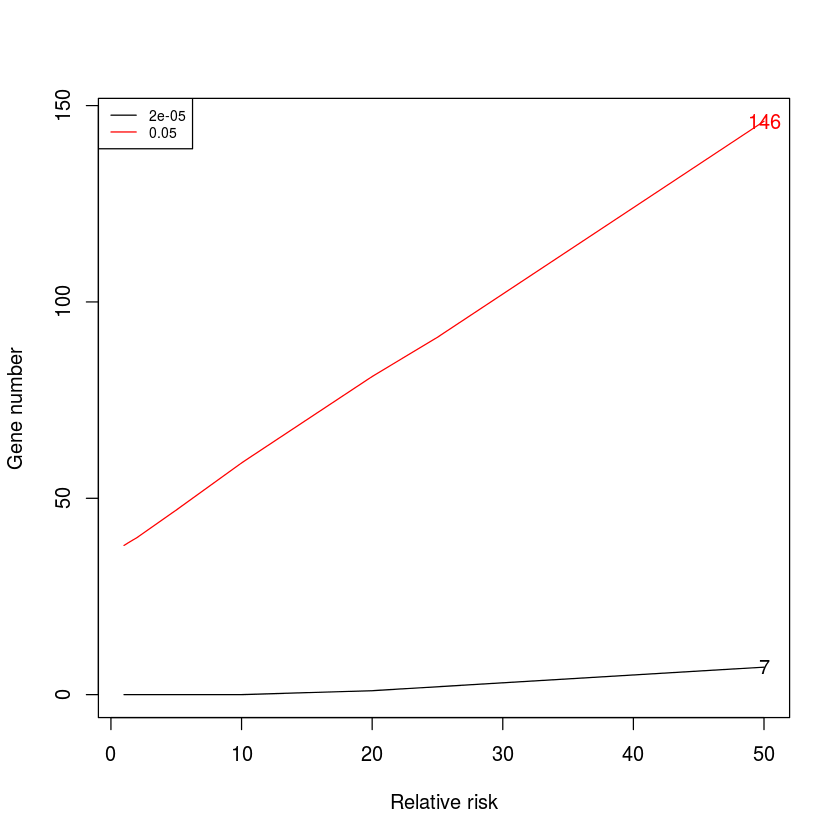

In [16]:
plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], gCountAll[ii, dim(gCountAll)[2]], 
        gCountAll[ii, dim(gCountAll)[2]], col  = ii)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)


gCount,0,0,0,0,0,0,3
gCount,0,0,0,0,1,2,7
gCount,0,0,0,0,2,3,11
gCount,4,4,5,6,9,11,23
gCount,13,15,16,20,27,32,55
gCount,38,40,47,59,81,91,146


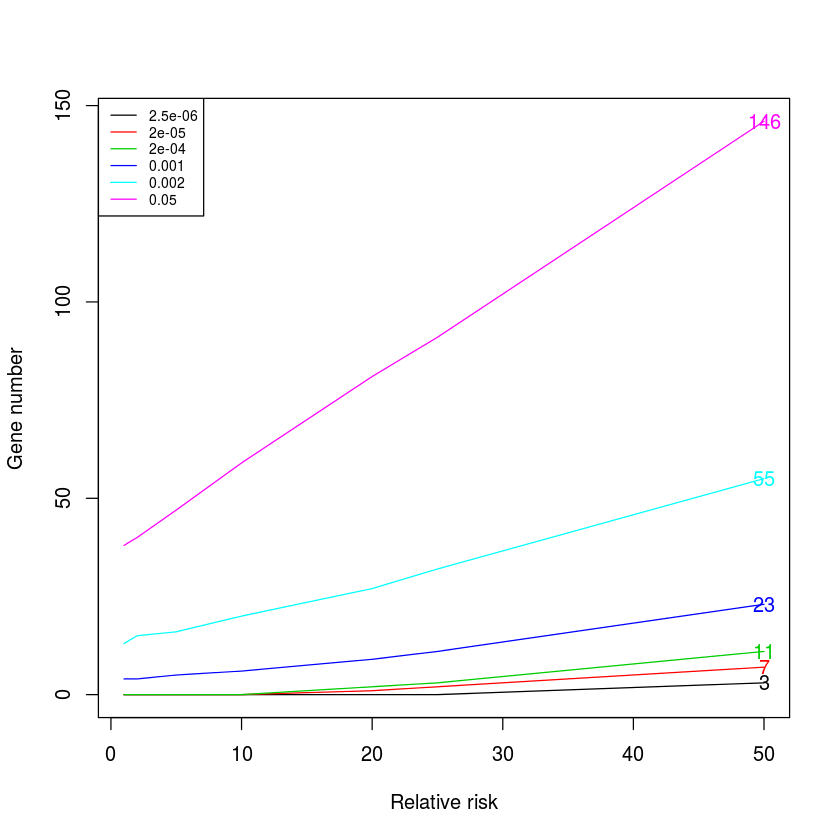

In [17]:
gCountAll <- NULL
alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
#alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){
  
outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y)
    length(y[y < alphaThreshold]))))
gCount <- apply(outData, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll


plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], gCountAll[ii, dim(gCountAll)[2]], 
        gCountAll[ii, dim(gCountAll)[2]], col  = ii)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)


### We will summarize how many counts for each RR below.
 

In [18]:
countSum <- lapply(geneCountList, function(x) apply(x, 2, sum))
countSum[[1]]
rrList

[1]  36  45  43  60  89  87 182

[1]  1  2  5 10 20 25 50

In [19]:
t.countSum <- do.call(rbind, countSum) ##See all simulated counts
apply(t.countSum, 2, range) ##See a range of all these values

head(t.countSum)

26,24,32,41,62,63,124
56,56,65,80,106,114,196


36,45,43,60,89,87,182
40,46,39,68,80,83,169
38,39,52,59,77,95,161
33,36,45,56,89,98,177
27,30,41,61,74,82,149
42,41,58,78,106,93,153


### Take a look at the predicted counts of de novos

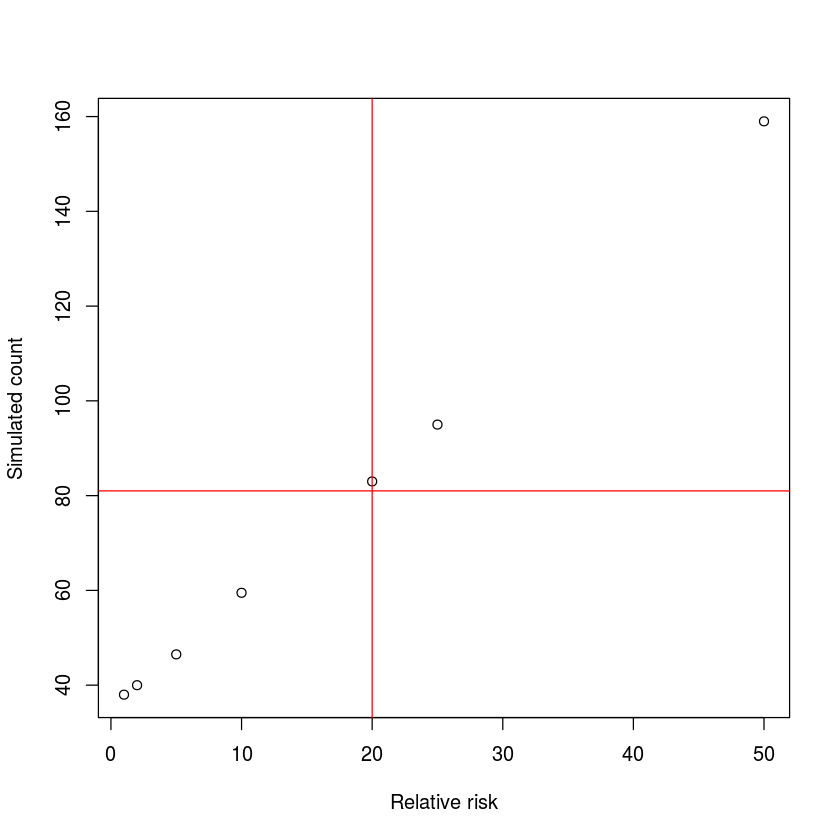

In [20]:
    Nsample_old <- 3985 + 356 ##There are 637 de novo mutations in this sample set
Nsample <- 550
Ncount_old <- 637
nPredictedDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )
    
countSumAverage <- apply(do.call(rbind, countSum), 2, median)

    
    
    plot(rrList, countSumAverage, xlab = 'Relative risk', ylab = 'Simulated count')
    
    abline(v = 20, col = 'red')
    abline(h = nPredictedDenovo, col = 'red') ## Draw a line for predicted counts



### Now, will check how many recurrent genes are from simulated data?

In [21]:
recurrentCount <- lapply(geneCountList, function(x) apply(x, 2, function(y) length(y[y>1])))
recurrentCount[[1]]

recurrentCountAll <- do.call(rbind, recurrentCount)

apply(recurrentCountAll, 2, median) ##Not strong, why is it? So, the way we let equal RRs for all risk genes is not suitable


[1]  0  0  1  2  3  2 18

[1]  0  0  0  0  2  3 11

### Take a look at the Poisson test result for all counts

In [22]:
poissonTestAll_data_allSimu[1:3, ]

apply(poissonTestAll_data_allSimu, 2, median)

poissonTestAll_data,6.013497e-01,1.183101e-01,1.914496e-01,3.606140e-04,4.443018e-13,2.551165e-12,9.956438e-65
poissonTestAll_data,3.457587e-01,9.058557e-02,4.068943e-01,3.833862e-06,8.082608e-10,7.347207e-11,5.978831e-56
poissonTestAll_data,4.709502e-01,4.068943e-01,1.266431e-02,5.949544e-04,7.974952e-09,1.810832e-15,9.253111e-51


[1] 4.709502e-01 3.457587e-01 7.936858e-02 4.777842e-04 7.347207e-11
[6] 1.810832e-15 1.726817e-49

# Use real counts from published data

## A little bit messy below, and not the results we want

## Use the data of AUT + EPI

Take a quick look at all information

#### DISEASE	NUM_INDIV

AUT	3985

CHD	362

EPI	356

ID	192

SCZ	1024

SIB_CONTROL	2049

### wc -l AUT+EPI.LoF.mut 

  637

(3985 AUT + 356 EPI) samples have 637 LoF mutations

#### Here, I randomly allocate counts to nGene, but counts should be allocated to the top 1000 genes


In [21]:
sum(data$dn.LoF)

[1] 308